In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib agg

import matplotlib.pyplot as plt
import numpy as np
import visualization
from data import datasets, evaluation
import transformation
import jax
import jax.numpy as jnp
from jax import tree_util
from transformation import MLP
import flax.linen as nn
from flax.core import freeze
import optax
from inference import point_estimate

rng_key = jax.random.PRNGKey(0)

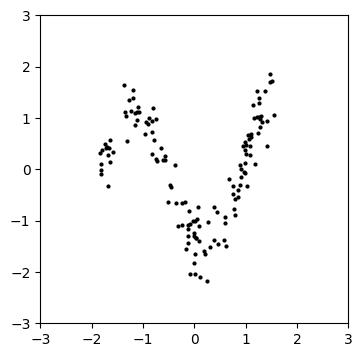

In [2]:
rng_key, rng_key_ = jax.random.split(rng_key)
#dataset = datasets.Izmailov(normalization="standardization")
dataset = datasets.Sinusoidal(normalization="standardization", rng_key=rng_key_, x_lower=0.0, x_upper=8.0)
rng_key, rng_key_ = jax.random.split(rng_key)
dataset_train, dataset_validate = dataset.split(rng_key_, 0.9)

X_train, y_train = dataset_train[:]
X_validate, y_validate = dataset_validate[:]

# visualization
figure = visualization.RegressionFigure()
figure.plot(data=dataset_train.data)

In [3]:
model_transformation = MLP([16, 1], activation=nn.tanh)
rng_key, rng_key_ = jax.random.split(rng_key)
parameters = {
    "transformation": model_transformation.init(rng_key_, X_train[0]),
    "log_std": 0.0
}

In [4]:
def ridge_loss(params, x, y):
    std = jnp.exp(params["log_std"])
    y_pred = model_transformation.apply(params["transformation"], x)
    squared_loss = jnp.power(y - y_pred, 2).sum()
    regularization = tree_util.tree_reduce(
        lambda a, b: a + b,
        tree_util.tree_map(lambda a: jnp.power(a, 2).sum(), params["transformation"])
    )
    loss = (0.5 / jnp.power(std, 2)) * squared_loss + x.shape[0] * jnp.log(std) + regularization
    return loss

In [5]:
# optimization
optimizer = optax.adam(learning_rate=0.001)
optimizer_state = optimizer.init(parameters)
loss = jax.jit(ridge_loss)

parameters, optimizer_state = point_estimate(
    loss_function=loss,
    parameters=parameters,
    inputs=X_train,
    outputs=y_train,
    epochs=4001,
    optimizer=optimizer,
    optimizer_state=optimizer_state,
    report_at=100
)

epoch 0 loss: 80.76459503173828
epoch 100 loss: 75.16682434082031
epoch 200 loss: 60.082603454589844
epoch 300 loss: 22.48680877685547
epoch 400 loss: -20.975360870361328
epoch 500 loss: -37.89000701904297
epoch 600 loss: -41.93434524536133
epoch 700 loss: -43.381324768066406
epoch 800 loss: -44.27818298339844
epoch 900 loss: -44.98821258544922
epoch 1000 loss: -45.560081481933594
epoch 1100 loss: -45.961090087890625
epoch 1200 loss: -46.246925354003906
epoch 1300 loss: -46.479087829589844
epoch 1400 loss: -46.67963409423828
epoch 1500 loss: -46.86058044433594
epoch 1600 loss: -47.022857666015625
epoch 1700 loss: -47.148597717285156
epoch 1800 loss: -47.22948455810547
epoch 1900 loss: -47.28411865234375
epoch 2000 loss: -47.33399963378906
epoch 2100 loss: -47.399375915527344
epoch 2200 loss: -47.49858856201172
epoch 2300 loss: -47.62457275390625
epoch 2400 loss: -47.760833740234375
epoch 2500 loss: -47.930198669433594
epoch 2600 loss: -48.09838104248047
epoch 2700 loss: -48.20172119140

'\nfor i in range(4001):\n    loss_val, grads = jax.value_and_grad(loss, 0)(params, X_train, y_train)\n    updates, optimizer_state = optimizer.update(grads, optimizer_state)\n    params = optax.apply_updates(params, updates)\n    \n    if i % 100 == 0:\n        print("loss", i, loss_val, jnp.exp(params["log_std"]))\n'

[[-0.5806301  -0.27773467 -0.4274449  -0.27531645  0.6724492  -0.28147495
  -0.2681432   0.26967618  0.5539498   1.0104754  -0.2643173   0.26913732
   0.5463624  -0.08795512  0.26305136  0.24822696 -1.4025947  -0.38835016
  -1.2348766  -0.38762686  1.497763   -0.38943496 -0.3856944   0.3861372
   1.3732306  -1.3032023  -0.3845071   0.385997    1.3647037  -0.36132333
   0.38400337  0.38076985  0.1896973   0.91056055 -0.72965854  0.68960077
  -0.725031   -1.0419905  -0.73608905 -0.7109715   0.7144341  -0.87409353
  -1.3851793  -0.704202    0.7141123  -0.86363614 -0.3189491   0.7016125
   0.6941333 ]]


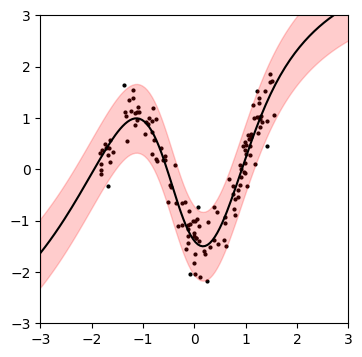

In [8]:
parameters_transformation = tree_util.tree_reduce(lambda a, b: jnp.concatenate([a.flatten(), b.flatten()]), parameters["transformation"])[jnp.newaxis]
print(parameters_transformation)

figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(
            alpha=1.0,
            aleatoric=True
        )
    ),
)
figure.plot(data=dataset_train.data, transformation=model_transformation.apply_from_vector, parameters=parameters_transformation, std=jnp.exp(parameters["log_std"]))

In [10]:
jnp.save("point_estimate_mlp_16_1_sinusoidal_0_8.npy", parameters_transformation)

In [12]:
print(parameters_transformation)

[[-0.5806301  -0.27773467 -0.4274449  -0.27531645  0.6724492  -0.28147495
  -0.2681432   0.26967618  0.5539498   1.0104754  -0.2643173   0.26913732
   0.5463624  -0.08795512  0.26305136  0.24822696 -1.4025947  -0.38835016
  -1.2348766  -0.38762686  1.497763   -0.38943496 -0.3856944   0.3861372
   1.3732306  -1.3032023  -0.3845071   0.385997    1.3647037  -0.36132333
   0.38400337  0.38076985  0.1896973   0.91056055 -0.72965854  0.68960077
  -0.725031   -1.0419905  -0.73608905 -0.7109715   0.7144341  -0.87409353
  -1.3851793  -0.704202    0.7141123  -0.86363614 -0.3189491   0.7016125
   0.6941333 ]]
